<a href="https://colab.research.google.com/github/simonka0808/AdaptiveSolutionsCorrectCode/blob/main/2022_CM4107_CW_1_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Submission Information
---

How to get the link to submit the notebook ?
*   Click the Share button (Top right corner)
*   In Get Link section, click change and choose **anyone with link**
* Make sure the access shows **"Editor"**
* Click on **Copy link**

Find below screenshot for reference.

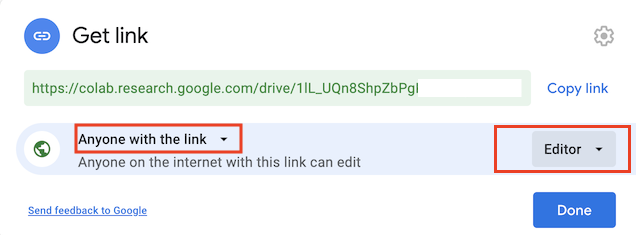

Please complete the below section

In [67]:
# Student Name = Simona Georgieva
# Student ID = 1900745  
# Student Email = s.georgieva@rgu.ac.uk

# Helper functions and imports

In [68]:
# Import required libraries
import pandas as pd
import numpy as np
import scipy.special

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import os
# helper to load data from PNG image files# helpe 
import imageio
# glob helps select multiple files using patterns
import glob
# helps to manipulate the image for rotation 


In [69]:
from __future__ import division # backward compatibility for python2
import operator
import random


np.random.seed(42)

## Import dataset

In [70]:
# file paths to MNIST on Colab
train_file = "sample_data/mnist_train_small.csv"
test_file = "sample_data/mnist_test.csv"

## Data Preprocessing

In [71]:
df_orig_train = pd.read_csv(train_file, header=None)  # read entire train dataset
df_orig_test = pd.read_csv(test_file, header=None)  # read entire test dataset
df_orig_train.info()

#all of the train data
y_train_all =  pd.get_dummies(df_orig_train[0]).values # Dataframes converted to ndarrays here
X_train_all = df_orig_train.drop(0, axis = 1).values
print(y_train_all.shape)
print(X_train_all.shape)
#all of the test data
y_test_all =  pd.get_dummies(df_orig_test[0]).values
X_test_all = df_orig_test.drop(0, axis = 1).values
print(y_test_all.shape)
print(X_test_all.shape)

# Select smaller samples of the train and test datasets (will execute faster when training our networks than using the entire dataset)
train_sample_size = 20000 # choosing a smaller sample instead of the entire dataset
random_indices = np.random.choice(range(len(y_train_all)), train_sample_size, replace = False)
X_train = X_train_all[random_indices]
y_train = y_train_all[random_indices]
print(y_train.shape)
print(X_train.shape)
#preprocessing normalise training data
X_train = (X_train / 255.0 * 0.99) + 0.01
y_train = y_train + 0.01
y_train = np.where(y_train != 1.01, y_train, 0.99)
print(y_train.shape)

# get a smaller test sample 
test_sample_size = 10000
random_test_indices = np.random.choice(range(len(y_test_all)), test_sample_size, replace = False)
X_test = X_test_all[random_test_indices]
y_test = y_test_all[random_test_indices]
print(y_test.shape)
print(X_test.shape)
#preprocessing normalise test data
X_test = (X_test / 255.0 * 0.99) + 0.01
y_test = y_test + 0.01
y_test = np.where(y_test != 1.01, y_test, 0.99)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 119.8 MB
(20000, 10)
(20000, 784)
(10000, 10)
(10000, 784)
(20000, 10)
(20000, 784)
(20000, 10)
(10000, 10)
(10000, 784)


In [72]:
def mean_squared_error(predictions, targets):
    """
    Calculates mean squared error of a model's predictions.
    """
    N=targets.size
    mse = ((targets - predictions) **2).sum() / (2*N)
    return mse


def accuracy(predictions, targets):
    """
    Calculates the accuracy of a model's predictions.
    """
    prediction_labels = np.argmax(predictions, axis=1)
    target_labels = np.argmax(targets, axis=1)
    predictions_correct = (prediction_labels == target_labels.round())
    accuracy = predictions_correct.mean()
    return accuracy

# TASK 1 - Activation functions for ANN
---

In labs you explored Sigmoid and ReLU.

In [73]:
class Activation_ReLU:
    def forward(self, x):
        return(np.maximum(0, x))
    def backward(self, x):
       return(np.greater_equal(x, 0).astype(int)) # inputs > 0 then convert bools to int
 
        
class Activation_Sigmoid:
    def forward(self, x):
        return(1 / (1 + np.exp(-x)))
    def backward(self, x):
        return(x * ( 1 - x))


## 1.1 (a) Implement LeakyReLU activation function

In [74]:
class Activation_LeakyReLU:
    def forward(self, inputs, alpha = 0.0001):
        # TODO: 
        return np.maximum(alpha*inputs,inputs)

    def backward(self, inputs, alpha = 0.0001):
        # TODO:  # inputs > ALPHA then convert bools to int
         # inputs > 0 then convert bools to int
        return(np.greater_equal(inputs, alpha).astype(int))

      

## 1.1 (b) Implement Linear activation function

In [75]:
class Activation_Linear:
    def forward(self, inputs, m=1, c=0):
       # TODO: # linear equation where m and c can be set
       return (m*inputs) + c


    def backward(self, inputs, m=1, c=0):
       # TODO:
       return m

In [76]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        # weights initialised from a gaussian with mean 0 and variance 1
        # multiply with a small value just to ensure we start with small weight values
        self.weights = 0.1*  np.random.normal(0.0, pow(n_inputs, -0.5), (n_inputs, n_neurons))
        self.biases = np.zeros((1, n_neurons))
       
    def forward(self, inputs, act):
        self.inputs = inputs #need this when backpropagating so maintain it in the layer class
        z = np.dot(inputs , self.weights) + self.biases # weights dot product
        self.outputs = act.forward(z) # nonlinear activation output of the layer
            
    def backward(self, error, act):
        delta = error * act.backward(self.outputs)
        self.dinputs = np.dot(delta, self.weights.T)  #this layer's error 
        
        N = self.dinputs.shape[0]
        self.dweights = np.dot(self.inputs.T, delta) / N  # derivatives for weights used by the optimizer class  
        self.dbiases = np.mean(delta, axis=0, keepdims=True) # derivatives for biases used by the optimizer class 
    
    
class Optimizer_SGD:
    def __init__(self, learningrate=0.3):
           self.lr = learningrate
            
    def weight_update(self, layer):       
        layer.weights -= self.lr * layer.dweights
        layer.biases -= self.lr * layer.dbiases

In [77]:
class ANN():
    def __init__(self, ouput_layer, act2, hidden_layer, act1, opt, batch_size = 10):
        self.layer2 = ouput_layer
        self.act2 = act2
        self.layer1 = hidden_layer
        self.act1 = act1
        self.opt = opt
        self.batch_size = batch_size

    def batch_input(self, x, y):
        for i in range(0, len(x), self.batch_size):
            yield (x[i:i + self.batch_size], y[i:i + self.batch_size])

    def train(self, x, y, epochs, opt, lr=0.3):
        opt.lr = lr

        monitoring = {}
        monitoring['mean_squared_error'] = []
        monitoring['accuracy'] = []

        for epoch in range(epochs):

            for (batch_x, batch_y) in self.batch_input(x, y):
                self.layer1.forward(batch_x, self.act1)
                self.layer2.forward(self.layer1.outputs, self.act2)

                #calculate the loss
                loss=(self.layer2.outputs-batch_y)
                
                # backprop through the layers 
                self.layer2.backward(loss, self.act2)
                self.layer1.backward(self.layer2.dinputs, self.act1)

                # update all the layer weights
                self.opt.weight_update(self.layer1)
                self.opt.weight_update(self.layer2)
               

            pred = self.predict(x)
            mse, acc = self.evaluate(pred, y)
            monitoring['mean_squared_error'].append(mse)
            monitoring['accuracy'].append(acc)

        monitoring_df = pd.DataFrame(monitoring)   
        return monitoring_df

    def predict(self, x):
        self.layer1.forward(x, self.act1)
        self.layer2.forward(self.layer1.outputs, self.act2)
        return self.layer2.outputs


    def embeddings(self, x, layer_type="layer1"):
        # layer_type defaults to output is useful for prediction
        # layer_type=layer1 is useful to get the compressed respresentation from the hidden layer
        
        self.layer1.forward(x, self.act1)
        self.layer2.forward(self.layer1.outputs, self.act2)

        if layer_type == "layer1": 
          return self.layer1.outputs  
        return self.layer2.outputs

    def evaluate(self, predicts, y):
        mse = mean_squared_error(predicts, y)
        acc = accuracy(predicts, y)
        return mse, acc

    def test(self, x, y):
        monitoring = {}
        pred = self.predict(x)
        mse, acc = self.evaluate(pred, y)
        monitoring['mean_squared_error'] = [mse]
        monitoring['accuracy'] = [acc]
        return pd.DataFrame(monitoring)


In [78]:
#  Set Other hyperparameters
np.random.seed(42)


## 1.2 Complete the experiments





In [79]:
print("This will take a few moments ...")

batch_sizes = 20
lr=0.3
epochs_sizes = [1,5,15,30]

act1 = Activation_ReLU()
act2 = Activation_Sigmoid()
act3 = Activation_LeakyReLU()
act4 = Activation_Linear()

sgd = Optimizer_SGD()

functions = {
    "ReLU": act1,
    "Sigmoid": act2,
    "LeakyRelu": act3,
    "Linear": act4
}

ann_dict = {}
train_results_dict = {}

for functionName in functions.keys():
  train_results_dict[functionName] = []
  ann_dict[functionName] = []
  for epochs in epochs_sizes:
    # configure the layers
    hidden_layer = Layer_Dense(784,200)
    output_layer = Layer_Dense(200,10)
    
    # create an ANN model
    ann = ANN(output_layer, functions[functionName], hidden_layer, act3, sgd, batch_sizes)
    
    train_performance = ann.train(X_train, y_train, epochs, sgd, lr)
    
    train_results_dict[functionName].append(train_performance)
    ann_dict[functionName].append(ann)
    print("leaving")
    
print(ann_dict)


This will take a few moments ...
leaving
leaving
leaving
leaving
leaving
leaving
leaving
leaving
leaving
leaving
leaving
leaving
leaving
leaving
leaving
leaving
{'ReLU': [<__main__.ANN object at 0x7f61ec09db10>, <__main__.ANN object at 0x7f61f0315f90>, <__main__.ANN object at 0x7f61ec0a4650>, <__main__.ANN object at 0x7f61ec184910>], 'Sigmoid': [<__main__.ANN object at 0x7f61ec0a4c10>, <__main__.ANN object at 0x7f61ec09d390>, <__main__.ANN object at 0x7f61ec0a48d0>, <__main__.ANN object at 0x7f61ec184990>], 'LeakyRelu': [<__main__.ANN object at 0x7f61ec094bd0>, <__main__.ANN object at 0x7f61ec094d10>, <__main__.ANN object at 0x7f61ec184b90>, <__main__.ANN object at 0x7f61ec859990>], 'Linear': [<__main__.ANN object at 0x7f61ec119250>, <__main__.ANN object at 0x7f61f0c01850>, <__main__.ANN object at 0x7f61ec0e5e10>, <__main__.ANN object at 0x7f61ec0a4550>]}


In [80]:
#iterate through each model and accumulate number of correct predictions
test_results = {}
for function in ann_dict:
  test_results[function] = []
  for model in ann_dict[function]:
    df_test_result = model.test(X_test, y_test)
    acc=df_test_result['accuracy'].values
    test_results[function].append(acc[0])
    pass
pass

print ("Accuracy Results \n {}".format(test_results))


Accuracy Results 
 {'ReLU': [0.9472, 0.9711, 0.9743, 0.9759], 'Sigmoid': [0.8971, 0.9463, 0.9653, 0.9699], 'LeakyRelu': [0.9463, 0.9723, 0.9744, 0.9746], 'Linear': [0.9392, 0.9668, 0.9709, 0.9695]}


## 1.3 lllustrate your evaluation findings

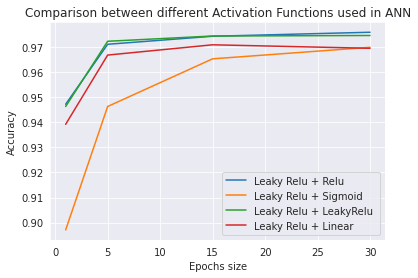

In [81]:

plt.xlabel("Epochs size")
plt.ylabel("Accuracy")
plt.title("Comparison between different Activation Functions used in ANN")
plt.plot(epochs_sizes, test_results["ReLU"] , label = "Leaky Relu + Relu ")
plt.plot(epochs_sizes, test_results["Sigmoid"] , label = "Leaky Relu + Sigmoid ")
plt.plot(epochs_sizes, test_results["LeakyRelu"] , label = "Leaky Relu + LeakyRelu ")
plt.plot(epochs_sizes, test_results["Linear"] , label = "Leaky Relu + Linear ")
 
plt.legend()
plt.show()

In [82]:
 # # TODO: ASSIGN THE OPTIMAL ACTIVATION FUNCTION TO THIS GLOBAL VARIABLE
BEST_act1 = Activation_ReLU #FILL THIS WITH THE OPTIMAL ACTIVATION FUNCTION YOU FOUND OUT
BEST_act2 = Activation_LeakyReLU()

## 1.4 Discuss the results of the experiments (200 words max)


<!-- Your explanation will go here -->

Based on the results from the graph, we can see that the model trained with ReLu has the best performance, closely followed by the model trained with LeakyRelu. 
We can see that the model with Sigmoid and Linear has a bit poorer performance.

More detailed analysis shows that as the number of epochs increases, the model's overall accuracy performs better for Leaky and LeakyRelu activation functions because the weights in the neural network are changed more times, and the curve goes from underfitting to optimal. 

In contrast, the model trained with the Linear function flattened
out after five epochs, and the accuracy declined. For example, the accuracy obtained with 15 epochs is 97,09%, while for 30 epochs 96% were recorded. Consequently, the model is no more learning from the training set. It learns the patterns of the sample data considerably. This makes the model over-fit and will not predict new inputs correctly.We can safely say we can stop the training process at that point.





# TASK 2 - Creating a twin kNN system for the ANN
---



In [83]:
# HELPER FUNCTIONS

#Within our class we now need code for each of the components of k-NN.
#First, lets create a method that will measure the distance between two vectors.
def euclidean(instance1, instance2):
        '''
        Calculates euclidean distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):            
            distance += pow((val1 - val2), 2)
        
        distance = pow(distance, 1/2)
             
              
        return 1 / (1+ distance)
    

def manhattan(instance1, instance2):
        '''
        Calculates manhattan distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):
            distance += abs(val1 - val2)      
              
        return 1 / (1+ distance)
    
def dot_product(instance1, instance2):
        '''
        Calculates dot product between two instances 
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        return np.dot(instance1, instance2)

def accuracy_knn(results):
        '''
        Returns the accuracy of predictions by comparing with the target
        results will be a List of Dictionaries. Each dictionary will contain
          the predicted value and the actual value
        '''
        correct = 0
        for predict, target in results:
            
            if predict == target:
                correct += 1
        return (correct/float(len(results))) * 100.0


def ann_prediction(ann_model, X, y):
    '''
    Returns predictions of an ANN model that are consistent with kNN test function
    '''
    results = [] # store the predictions returned by ANN
    pred = ann_model.predict(X)  # get the predictions
    predict_label_list = np.argmax(pred, axis=1)  # index of max value in list as predicted digit
    predict_label_list= predict_label_list.tolist()  # convert to list
    target_label_list = np.argmax(y, axis=1)  # index of max value in list as target digit
    target_label_list= target_label_list.tolist()  # convert to list
    for predict_label, target_label in zip(predict_label_list, target_label_list):
        results.append([predict_label, target_label])
    return results


## 2.1 Create a method to compute faithfulness between predictions

In [84]:
def faithfulness(predictions_1, predictions_2):
        '''
        Given two sets of predictions from two different ML algorithms, this will 
        check the rate of agreement between the two sets of predictions. 
        Here predictions_1 will be a List of Lists. Each inner List will contain a
          pair of predicted value and the actual value
        predictions_2 will be a List of Lists. Each inner List will contain a
          pair of predicted value and the actual value
        '''
        match = 0
        # TODO: compare predictions and maintain agreement
        for pred in range(len(predictions_1)):
          if predictions_1[pred] == predictions_2[pred]:
            match += 1

        
        return (match/float(len(predictions_1))) * 100.0

In [85]:
class kNN:
    """
    Parameters
    X_train, Y_train : list
    these consists of the training set feature values and associated class labels
    k : int
    specify the number of neighbours
    sim : literal
    specify the name of the similarity metric (e.g. manhattan, eucliedean)
    weighted : Boolean
    specify the voting strategy as weighted or not weighted by similarity values
  
    Attributes
    -----------  
    Results : list
      Target and predicted class labels for the test data.    
    """


    def __init__(self, X_train, Y_train, k=3, sim=manhattan, weighted=False):
        self.X_train = X_train
        self.Y_train = Y_train
        
        if k <= len(self.X_train):
            self.k = k # set the k value for neighbourhood size
        else:
            self.k = len(self.X_train) # to ensure the get_neighbours dont crash
    
        self.similarity = sim # specify a sim metric that has been pre-defined e.g. manhattan or euclidean
        
        self.weighted = weighted # boolean to choose between weighted / unweighted majority voting
        
        #store results from testing 
        self.results= []
        
    #With k-NN, we are interested in finding the k number of points with the greatest similarity 
    # to the the query or test instance.
    def get_neighbours(self, test_instance):
        '''
        Locate most similar neighbours 
        X_train will be a containing features (Float) values (i.e. your training data)
        Y_train will be the corresponding class labels for each instance in X_train
        test_instance will be a List of Float values (i.e. a query instance)
        '''
        similarities = [] # collection to store the similarities to be computed

        for train_instance, y in zip(self.X_train, self.Y_train): #for each member of the training set
            sim = self.similarity(test_instance, train_instance) #calculate the similarity to the test instance
            
            similarities.append((y, sim)) #add the actual label of the example and the computed similarity to a collection 
        #print(distances)
        similarities.sort(key = operator.itemgetter(1), reverse = True) #sort the collection by decreasing similarity
        neighbours = [] # holds the k most similar neighbours
        neighbours = [similarities[x] for x in range(self.k)] #extract the k top indices of the collection for return

        return neighbours

    # given the neighbours make a prediction
    # the boolean parameter when set to False will use unweighted majority voting; otherwise weighted majority voting
    # weighting can be helpful to break any ties in voting
    def predict(self, neighbours):
        '''
        Summarise a prediction based upon weighted neighbours calculation
        '''
        class_votes = {}
        for x in range(len(neighbours)):
            response = neighbours[x][0]
            if response in class_votes:
                class_votes[response] += (1-self.weighted) + (self.weighted * neighbours[x][1]) #if not weighted simply add 1
                #class_votes[response] += [1, neighbours[x][1]][weighted == True] 
              
            else:
                class_votes[response] = (1-self.weighted) + (self.weighted * neighbours[x][1])
                #class_votes[response] = [1, neighbours[x][1]][weighted == True] 
                
        #print(class_votes)
        sorted_votes = sorted(class_votes, key = lambda k: (class_votes[k], k), reverse = True)
        #print(sorted_votes)
        return sorted_votes[0]
    
    #iterate through all the test data to calculate accuracy
    def test(self, X_test, Y_test):
        self.results = [] # store the predictions returned by kNN

        for test_instance, target_label in zip(X_test, Y_test):
            neighbours = self.get_neighbours(test_instance)
            predict_label = self.predict(neighbours)
            self.results.append([predict_label, target_label])
            #print('> predicted = ', result,', actual = ', test_label)
    

In [86]:
# Set hyperparameters
ks = [1, 5, 11, 21, 51]  # try a few different values for k
train_size = 800 # or use the earlier specified "train_sample_size" which may take longer to compute
test_size = 200 # or use the earlier specified "test_sample_size" which may take longer to compute

## 2.2 Create a compressed version of the training and test sets using the ANN layer activations

In [87]:
# Use the following ANN configuration as your black-box model which needs a twinned kNN explanation
# Configure, Create and use this ANN to get embedings and predictions
batch_size = 20
epochs = 20
sgd = Optimizer_SGD()
lr = 0.3
# configure the layers
hidden_layer = Layer_Dense(784,200)
act1 = Activation_ReLU()
output_layer = Layer_Dense(200,10)
act2 = Activation_Sigmoid()

# create an ANN model
ann = ANN(output_layer, act2, hidden_layer, act1, sgd, batch_size) 
train_performance = ann.train(X_train, y_train, epochs, sgd, lr) # train the model


In [88]:
#  TODO: layer 1 compression - hint use ann.embeddings and flattened as needed
X_train_compressed_1 = ann.embeddings(X_train, "layer1")
X_test_compressed_1 =  ann.embeddings(X_test, "layer1")


# TODO: layer 2 compression - hint use ann.embeddings and flattened as needed
X_train_compressed_2 = ann.embeddings(X_train, "layer2")
X_test_compressed_2 = ann.embeddings(X_test, "layer2")


## 2.3 Setup an evaluation to compare to what extent a kNN aligns with the predictions of the ANN with the raw data versus the compressed data

In [89]:
# CONVERT Y Values to single class not one hot encoding
# because KNN implementation supports only one class
y_train_knn = np.argmax(y_train, axis=1)
y_train_knn= y_train_knn.tolist()

y_test_knn = np.argmax(y_test, axis=1)
y_test_knn= y_test_knn.tolist()


In [90]:
# faithfulness using raw data (uncompressed)

knn_list = []
knn_exp = {"compression": "No Compression", "faithfulness": []}  # a dictionary to maintain compression type and faithfulness scores
for k in ks: # determine faithfulness for different values of k
  #create the different instances of the kNN class
  knn = kNN(X_train[:train_size], y_train_knn[:train_size], k, euclidean, weighted=True)
  knn.test(X_test[:test_size], y_test_knn[:test_size]) # now get the predictions on the test set
  knn_exp['faithfulness'].append(faithfulness(knn.results, ann_prediction(ann, X_test[:test_size], y_test[:test_size])))

print("kNN Faithfulness to ANN on test set is: ", knn_exp)
knn_list.append(knn_exp)


kNN Faithfulness to ANN on test set is:  {'compression': 'No Compression', 'faithfulness': [87.5, 88.0, 87.5, 86.5, 81.0]}


In [91]:
# faithfulness using layer 1 compression


knn_exp = {"compression": "Layer 1 Compression", "faithfulness": []}

# TODO:
for k in ks:
  knn = kNN(X_train_compressed_1[:train_size],y_train_knn[:train_size], k, euclidean, weighted=True)
  knn.test(X_test_compressed_1[:test_size], y_test_knn[:test_size])
  knn_exp['faithfulness'].append(faithfulness(knn.results, ann_prediction(ann, X_test[:test_size], y_test[:test_size])))
  


print("Layer1 ", knn_exp)
knn_list.append(knn_exp)

Layer1  {'compression': 'Layer 1 Compression', 'faithfulness': [92.5, 96.0, 94.0, 93.0, 93.0]}


In [92]:
# faithfulness using layer 2 compression

knn_exp = {"compression": "Layer 2 Compression", "faithfulness": []}

# TODO:
for k in ks:
  knn = kNN(X_train_compressed_2[:train_size], y_train_knn[:train_size], k , euclidean, weighted=True)
  knn.test(X_test_compressed_2[:test_size], y_test_knn[:test_size])
  knn_exp['faithfulness'].append(faithfulness(knn.results, ann_prediction(ann, X_test[:test_size], y_test[:test_size])))

print("Layer2 ", knn_exp)
knn_list.append(knn_exp)

Layer2  {'compression': 'Layer 2 Compression', 'faithfulness': [95.5, 99.0, 99.5, 99.5, 99.0]}


## 2.3 Plot a graph that compares the faithfulness of the uncompressed and compressed versions of kNN to ANN and explain findings

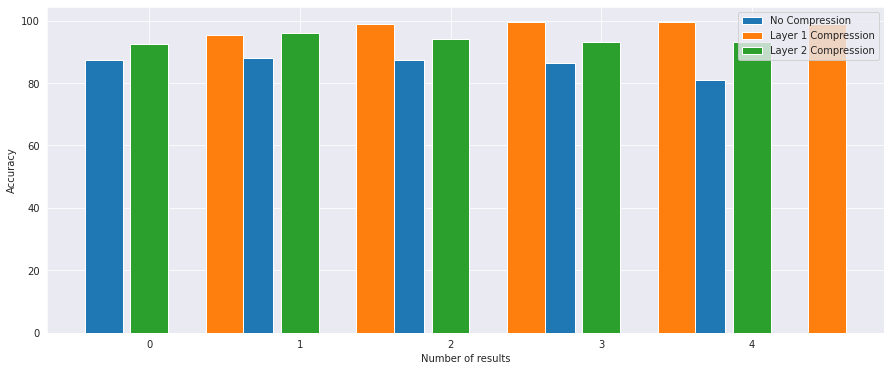

In [95]:
N = len(ks) # this is the number of results we want to plot on the x-axis
ind = np.arange(N) # x axis index
# print(knn_list)

plt.figure(figsize=(15,6))
plt.xlabel("Number of results")
plt.ylabel("Accuracy")
width = 0.25 # width of the bar      
plt.bar(ind-0.3, knn_list[0]['faithfulness'], width, label=knn_list[0]['compression'])

# TODO: add layer1 and 2 compressed results to the plot and format the graph
plt.bar(ind + 0.5, knn_list[2]['faithfulness'], width, label=knn_list[2]['compression'])
plt.bar(ind, knn_list[1]['faithfulness'], width, label=knn_list[1]['compression'])
plt.legend(["No Compression","Layer 1 Compression", "Layer 2 Compression"])




plt.show()

### Explain your findings in no more than 200 words.  

<!-- Your explanation will go here -->
Based on the results from the graph we can assume that the model achieves better results with compressed data. 